## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import pyplot, transforms
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
parent_dir = Path.cwd().parent.parent.parent

"""
This code is used for Fig1.C. Spatial patterns of county-level facility-based acc in 2014, 2019 and 2024.  
Data: (1) U.S. Boundaries, (2) U.S. equity data
"""

'\nThis code is used for Fig1.C. Spatial patterns of county-level facility-based acc in 2014, 2019 and 2024.  \nData: (1) U.S. Boundaries, (2) U.S. equity data\n'

## Data Processing

In [2]:
def combine_data_equity(usa_map_gdf, start_year, end_year, evse_name):
    """
    Combine USA map data with equity metrics (Gini coefficients) for multiple years.
    """
    # Initialize final GeoDataFrame
    final_gdf = usa_map_gdf.copy()
    
    # Process data for each year
    for year in range(start_year, end_year + 1):
        # Read equity data file
        acc_file = parent_dir / 'data' / 'US-equity' / 'facility-based' / f'{year}_poi_1km' / f'{year}_gini_summary_{evse_name}.csv'
        acc_data = pd.read_csv(acc_file)
        
        # Merge map data with Gini coefficients
        matched_df = pd.merge(usa_map_gdf, acc_data[['GID_2', 'Gini_Coefficient']], on='GID_2', how='inner')
        matched_df = matched_df.rename(columns={'Gini_Coefficient': f'Year{year}'})
        
        # Merge year data into final GeoDataFrame
        final_gdf = pd.merge(final_gdf, matched_df[['GID_2', f'Year{year}']], on='GID_2', how='left')
    
    # Ensure geometry column is preserved and fill missing values
    final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry').fillna(2)
    
    print(f"Combined equity data for {end_year - start_year + 1} years ({start_year}-{end_year})")
    print(f"Final shape: {final_gdf.shape}")
    
    return final_gdf


def combine_data_evcs(usa_map_gdf, year, evse_name):
    """
    Process EVCS data for a specific year and aggregate by administrative regions.
    """
    # Read EVCS data file
    evse_file = parent_dir / 'data' / 'US-EV-Station-2014-2024' / f'alt_fuel_stations_historical_day (Dec 31 {year}).geojson'
    usa_evse = gpd.read_file(evse_file)
    
    # Ensure consistent coordinate reference system
    usa_map_gdf = usa_map_gdf.to_crs(epsg=4326)
    usa_evse = usa_evse.to_crs(epsg=4326)
    
    # Perform spatial join to assign EV stations to administrative regions
    joined_data = gpd.sjoin(usa_evse, usa_map_gdf, how="inner", predicate="within")
    
    # Convert EVSE count columns to numeric and calculate totals
    evse_columns = ['ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num']
    for col in evse_columns:
        joined_data[col] = pd.to_numeric(joined_data[col], errors='coerce').fillna(0)
    
    joined_data['evse_num'] = joined_data[evse_columns].sum(axis=1)
    
    # Aggregate data by administrative region
    aggregated_data = joined_data.groupby('GID_2')[evse_name].sum().reset_index()
    aggregated_data = aggregated_data.rename(columns={evse_name: f'Year{year}'})
    
    print(f"Processed EVCS data for {year}: {len(aggregated_data)} regions")
    
    return aggregated_data


def filter_year_data(usa_map_gdf, evse_name, start_year, end_year):
    """
    Combine equity data with EVCS data and filter regions with no EV stations.
    """
    # Load equity data (Gini coefficients)
    final_gdf_all_gini = combine_data_equity(usa_map_gdf, 2014, 2024, evse_name)
    
    # Process each year to filter regions without EV stations
    for year in range(start_year, end_year + 1):
        # Get EVCS data for current year
        evcs_data = combine_data_evcs(usa_map_gdf, year, evse_name)
        
        # Identify regions with EV stations (value != 0)
        regions_with_ev = evcs_data[evcs_data[f'Year{year}'] != 0]['GID_2']
        
        # Mark regions without EV stations as 2
        final_gdf_all_gini.loc[~final_gdf_all_gini['GID_2'].isin(regions_with_ev), f'Year{year}'] = 2
    
    print(f"Filtered data for years {start_year}-{end_year}")
    print(f"Regions with EV stations identified and marked")
    
    return final_gdf_all_gini

In [3]:
# read u.s. boudaries
usa_map_file = parent_dir / 'data' / 'US-map'/ 'usa_map.geojson'
usa_map_gdf = gpd.read_file(usa_map_file)
usa_map_gdf = usa_map_gdf[['GID_0', 'GID_1', 'GID_2', 'COUNTRY', 'NAME_1', 'NAME_2', 'geometry']]

# joining map with equity values
final_gdf_all_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='evse_num')
final_gdf_dc_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='ev_dc_fast_num')
final_gdf_l1_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='ev_level1_evse_num')
final_gdf_l2_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='ev_level2_evse_num')

# filter counties with no evcs
final_gdf_all_evse = filter_year_data(usa_map_gdf, 'evse_num',2014,2024)
final_gdf_dc_evse = filter_year_data(usa_map_gdf, 'ev_dc_fast_num',2014,2024)
final_gdf_l1_evse = filter_year_data(usa_map_gdf, 'ev_level1_evse_num',2014,2024)
final_gdf_l2_evse = filter_year_data(usa_map_gdf, 'ev_level2_evse_num',2014,2024)


# filter columns（Year2014 - Year2023）
columns_to_plot = ['Year2014','Year2015','Year2016', 'Year2017', 'Year2018', 'Year2019', 'Year2020', 'Year2021', 'Year2022', 'Year2023', 'Year2023','Year2024']

# tag
final_gdf_all_evse['EVSE_Type'] = 'All EVSE'
final_gdf_dc_evse['EVSE_Type'] = 'DC EVSE'
final_gdf_l1_evse['EVSE_Type'] = 'L1 EVSE'
final_gdf_l2_evse['EVSE_Type'] = 'L2 EVSE'

Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5


Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions
Processed EVCS data for 2015: 1099 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2016: 1275 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2017: 1364 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2018: 1433 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions
Processed EVCS data for 2015: 1099 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2016: 1275 regions
Processed EVCS data for 2017: 1364 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2018: 1433 regions
Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2015: 1099 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2016: 1275 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2017: 1364 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2018: 1433 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions
Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2015: 1099 regions
Processed EVCS data for 2016: 1275 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2017: 1364 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2018: 1433 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions
Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked


## Visualization: facility-based acc.

In [4]:
def merge_geometries_by_attribute(gdf, groupby_column='NAME_1', crs=4326):
    """
    Merge geometries in a GeoDataFrame by grouping them based on a specified attribute column.
    """
    # Dictionary to store merged geometries
    merged_geometries = {}
    
    # Group by specified column and merge geometries for each group
    for name, group in gdf.groupby(groupby_column):
        # Use unary_union to merge multiple polygons into one (if overlaps exist)
        # If only one geometry exists in group, use it directly
        if group['geometry'].size > 1:
            merged_geom = unary_union(group['geometry'].tolist())
        else:
            merged_geom = group['geometry'].iloc[0]
        merged_geometries[name] = merged_geom
    
    # Create new DataFrame to store merged results
    merged_df = pd.DataFrame.from_dict(merged_geometries, orient='index', columns=['geometry'])
    merged_gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')
    
    # Add original grouping column as attribute column
    merged_gdf[groupby_column] = merged_gdf.index
    
    # Reset index to get clean sequential indexing
    merged_gdf.reset_index(drop=True, inplace=True)
    
    # Set Coordinate Reference System for the output GeoDataFrame
    merged_gdf_with_crs = merged_gdf.set_crs(epsg=crs)
    
    return merged_gdf_with_crs

In [8]:
def plot_evse_accessibility(gdf, merged_gdf, year_column, area, figsize=(10,6), dpi=150):
    """
    Population-based Accessibility Map
    """
    # Define CRS (Coordinate Reference System)
    albers_proj = '+proj=aea +lat_1=20 +lat_2=60 +lon_0=0'
    
    # Define fonts
    font1 = {'family':'Arial', 
            'style':'italic',
            'weight':'normal', 
            'color':'black',
            'size':6
           }
    
    font2 = {'family':'Arial',
            'weight':'normal',
            'size':6
           }
    
    font3 = {'family':'fantasy',
            'weight':'bold', 
            'color':'teal'
           }
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    plt.rcParams['legend.labelspacing'] = 0.8
    plt.rcParams['legend.title_fontsize'] = 8
    
    base = pyplot.gca().transData
    rot = transforms.Affine2D().rotate_deg(60)
    
    mask = gdf[year_column] == 2
    gdf_plot = gdf.copy()
    gdf_plot.loc[mask, year_column] = np.nan
    
    ax = merged_gdf.to_crs(albers_proj).plot(ax=ax, aspect='equal', 
                                          facecolor='none', edgecolor='black', 
                                          linewidth=0.25, alpha=0.5, zorder=11, 
                                          transform=rot+base)
    
    ax = gdf_plot.to_crs(albers_proj).plot(ax=ax,
                                         column=year_column,
                                         cmap='Greens',
                                         missing_kwds={
                                             "color": "lightgray",
                                             "edgecolor": "white",
                                             "hatch": "//",
                                             "label": "accessibility = 0"},
                                         facecolor='lightgrey',
                                         legend=False,
                                         scheme='UserDefined',
                                         classification_kwds={
                                             'bins': [0.80,0.90,0.94,0.98]
                                         },
                                         alpha=0.99,
                                         edgecolor='white',
                                         linewidth=0.15,
                                         legend_kwds={
                                             'loc': 'lower right',
                                             'title': 'Legend',
                                             'shadow':False,
                                             'prop': font2,
                                             "fmt": "{:.0f}"
                                         },
                                         zorder=2,
                                         transform=rot+base
                                         )
    
    # u.s.areas
    if area == 'mainland':
        # mainland u.s.
        ax.set_ylim(-3600000, 0)
        ax.set_xlim(-12800000, -7300000)
    elif area == 'HI':
        # Hawaii
        ax.set_ylim(-2500000, -1000000)
        ax.set_xlim(-17000000, -15500000)
    elif area == 'AK':
        # Alaska
        ax.set_ylim(450000, 3000000)
        ax.set_xlim(-15800000, -12000000)
    
    ax.axis('off')
    
    return fig, ax

## Test run

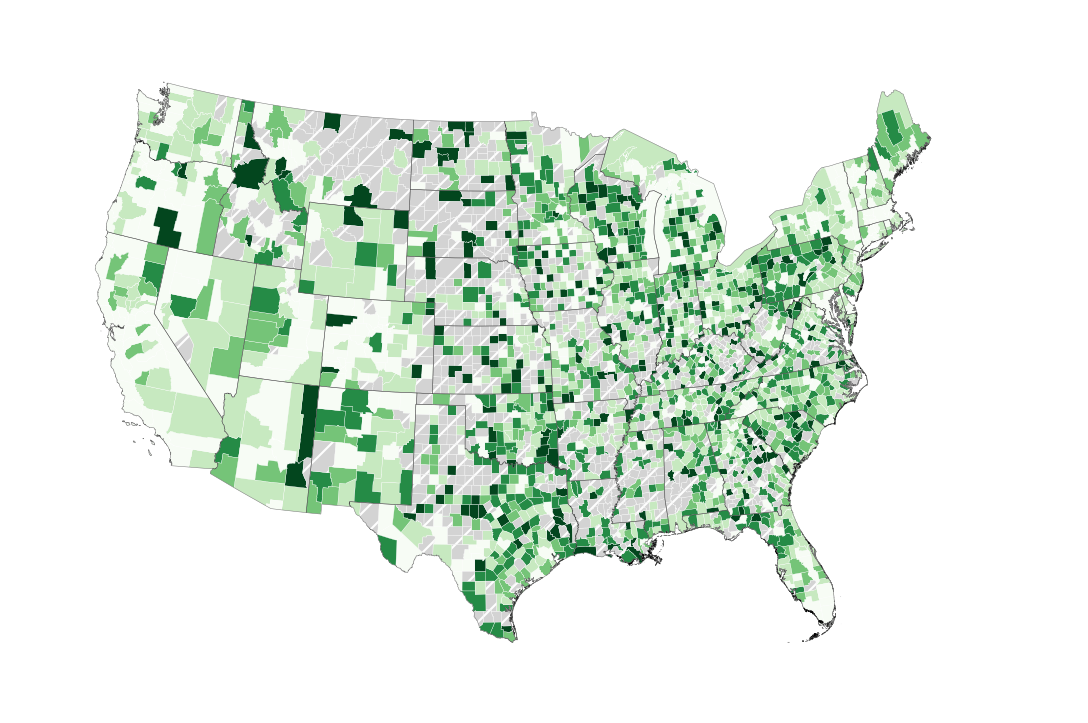

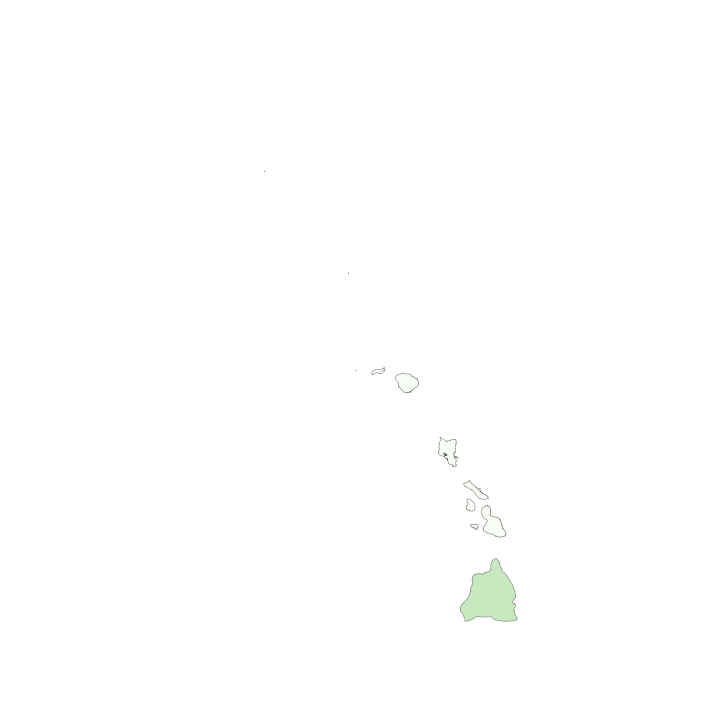

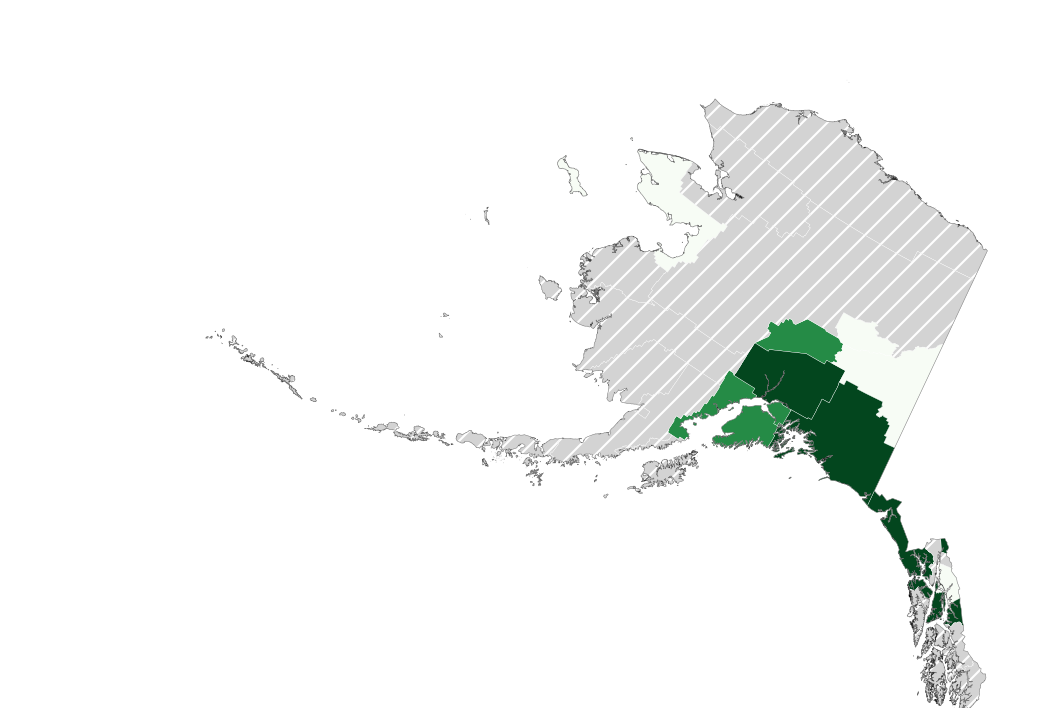

In [9]:
if __name__ == "__main__":
    # Merge geometries by state name
    merged_gdf = merge_geometries_by_attribute(usa_map_gdf, 'NAME_1')
    
    # mainland u.s.
    fig1, ax1 = plot_evse_accessibility(final_gdf_all_evse, merged_gdf, 'Year2024', area='mainland')
    
    # HI
    fig2, ax2 = plot_evse_accessibility(final_gdf_all_evse, merged_gdf, 'Year2024', area='HI')
    
    # AK
    fig3, ax3 = plot_evse_accessibility(final_gdf_all_evse, merged_gdf, 'Year2024', area='AK')
    
    plt.show()